In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics, optimizers
import numpy as np
import matplotlib.pyplot as plt


In [379]:
# Parameters
LATENT_DIM = 25
CRITIC_STEPS = 3
GP_WEIGHT = 10
IMG_SIZE = 28

In [380]:
# Import MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [381]:
# Preprocess the data
X = (X.astype("float32") - 127.5) / 127.5

In [382]:
critic_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

x = layers.Conv2D(16, kernel_size=3, strides=2, padding="same", activation="gelu", kernel_initializer="he_normal")(critic_input)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="gelu", kernel_initializer="he_normal")(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="gelu", kernel_initializer="he_normal")(x)
critic_output = layers.Dense(1)(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_68 (Conv2D)          (None, 13, 13, 16)        272       
                                                                 
 conv2d_69 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 flatten_34 (Flatten)        (None, 1568)              0         
                                                                 
 dense_114 (Dense)           (None, 256)               401664    
                                                                 
 dense_115 (Dense)           (None, 1)                 257       
                                                                 
Total params: 406833 (1.55 MB)
Trainable params: 406833 (1

In [383]:
generator_input = layers.Input(shape=(LATENT_DIM,))

x = layers.Dense(128, activation="gelu", kernel_initializer="he_normal")(generator_input)
x = layers.Dense(7*7*16, activation="gelu", kernel_initializer="he_normal")(x)
x = layers.Reshape((7, 7, 16))(x)

x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", use_bias=False, activation="gelu", kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9)(x)

x = layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", use_bias=False, activation="gelu", kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9)(x)

x = layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding="same", activation="tanh")(x)

generator_output = layers.Reshape((IMG_SIZE, IMG_SIZE))(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_72 (InputLayer)       [(None, 25)]              0         
                                                                 
 dense_116 (Dense)           (None, 128)               3328      
                                                                 
 dense_117 (Dense)           (None, 784)               101136    
                                                                 
 reshape_72 (Reshape)        (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose_128 (Conv  (None, 14, 14, 16)        2304      
 2DTranspose)                                                    
                                                                 
 batch_normalization_94 (Ba  (None, 14, 14, 16)        64        
 tchNormalization)                                        

In [384]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [385]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=LATENT_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

# Compile the GAN

lr = 0.0008

wgangp.compile(
    c_optimizer=keras.optimizers.Adam(learning_rate=lr),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr)
)

In [386]:
# Create a custom calback that plots generated images after each epoch
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, samples_count=6):
        self.samples_count = samples_count

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.samples_count, LATENT_DIM))

        fake_images = wgangp.generator(random_latent_vectors, training=True)

        plt.figure(figsize=(self.samples_count, 2))
        for i in range(self.samples_count):
            plt.subplot(2, self.samples_count // 2, i + 1)
            plt.imshow(fake_images[i].numpy().reshape(IMG_SIZE, IMG_SIZE), cmap="binary")
            plt.axis("off")
            
        plt.show()
        

In [387]:
# Delete previous logs
import shutil
shutil.rmtree('./logs', ignore_errors=True)

# Tensorboard callback
from keras.callbacks import TensorBoard
tensorboard_cb = TensorBoard(log_dir='./logs')

Epoch 1/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -9.9024 - c_wass_loss: -12.8250 - c_gp: 0.2923 - g_loss: -3.1911

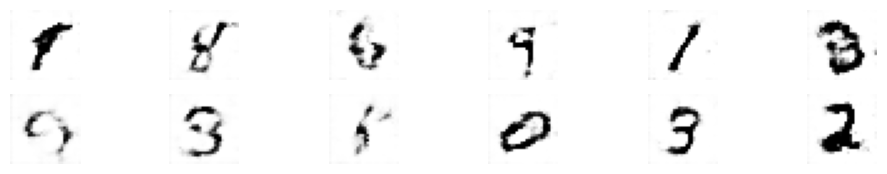

1094/1094 [==============================] - 39s 25ms/step - c_loss: -9.8997 - c_wass_loss: -12.8210 - c_gp: 0.2921 - g_loss: -3.1893
Epoch 2/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -4.8154 - c_wass_loss: -5.8604 - c_gp: 0.1045 - g_loss: -0.9683

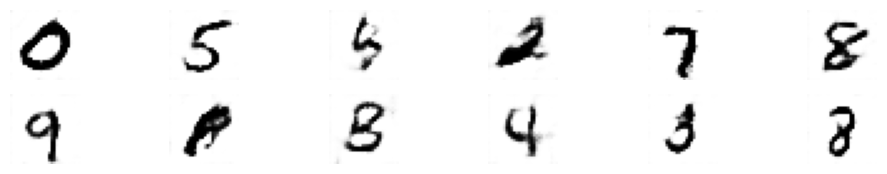

1094/1094 [==============================] - 28s 26ms/step - c_loss: -4.8143 - c_wass_loss: -5.8588 - c_gp: 0.1045 - g_loss: -0.9668
Epoch 3/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -4.0080 - c_wass_loss: -4.8534 - c_gp: 0.0845 - g_loss: -0.8760

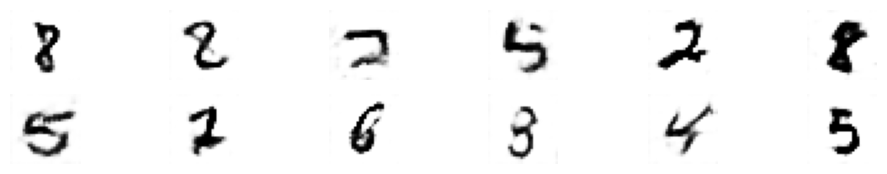

1094/1094 [==============================] - 28s 25ms/step - c_loss: -4.0068 - c_wass_loss: -4.8530 - c_gp: 0.0846 - g_loss: -0.8738
Epoch 4/15
1094/1094 [==============================] - ETA: 0s - c_loss: -3.5884 - c_wass_loss: -4.3487 - c_gp: 0.0760 - g_loss: -0.6802

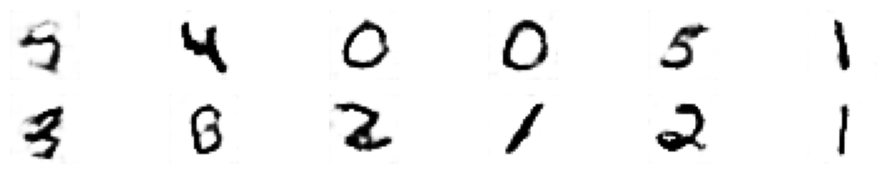

1094/1094 [==============================] - 28s 26ms/step - c_loss: -3.5884 - c_wass_loss: -4.3487 - c_gp: 0.0760 - g_loss: -0.6802
Epoch 5/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -3.2934 - c_wass_loss: -3.9990 - c_gp: 0.0706 - g_loss: -0.7936

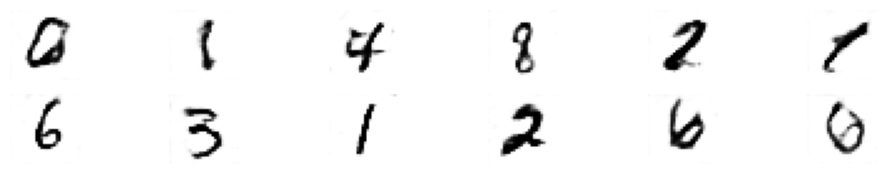

1094/1094 [==============================] - 28s 25ms/step - c_loss: -3.2928 - c_wass_loss: -3.9984 - c_gp: 0.0706 - g_loss: -0.7937
Epoch 6/15
1094/1094 [==============================] - ETA: 0s - c_loss: -3.0801 - c_wass_loss: -3.7447 - c_gp: 0.0665 - g_loss: -0.8486

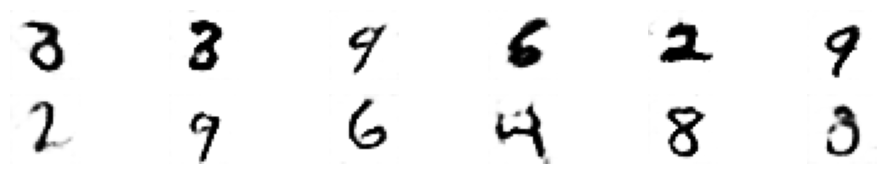

1094/1094 [==============================] - 28s 25ms/step - c_loss: -3.0801 - c_wass_loss: -3.7447 - c_gp: 0.0665 - g_loss: -0.8486
Epoch 7/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -2.8301 - c_wass_loss: -3.4168 - c_gp: 0.0587 - g_loss: -1.0406

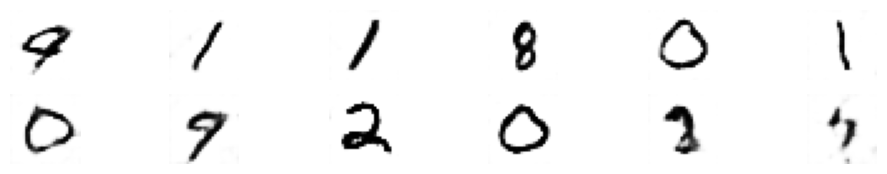

1094/1094 [==============================] - 28s 26ms/step - c_loss: -2.8305 - c_wass_loss: -3.4172 - c_gp: 0.0587 - g_loss: -1.0400
Epoch 8/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -2.6888 - c_wass_loss: -3.2432 - c_gp: 0.0554 - g_loss: -1.2591

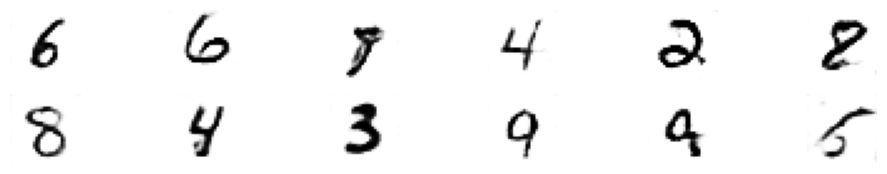

1094/1094 [==============================] - 28s 26ms/step - c_loss: -2.6874 - c_wass_loss: -3.2420 - c_gp: 0.0555 - g_loss: -1.2589
Epoch 9/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -2.5935 - c_wass_loss: -3.1275 - c_gp: 0.0534 - g_loss: -1.3063

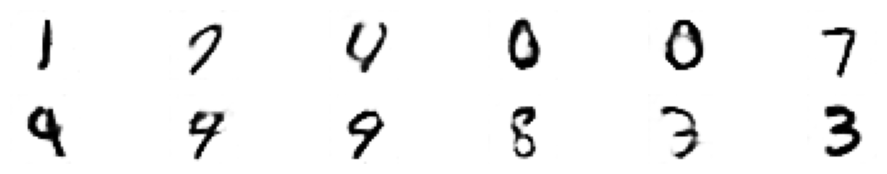

1094/1094 [==============================] - 28s 26ms/step - c_loss: -2.5947 - c_wass_loss: -3.1288 - c_gp: 0.0534 - g_loss: -1.3058
Epoch 10/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -2.4470 - c_wass_loss: -2.9526 - c_gp: 0.0506 - g_loss: -1.3683

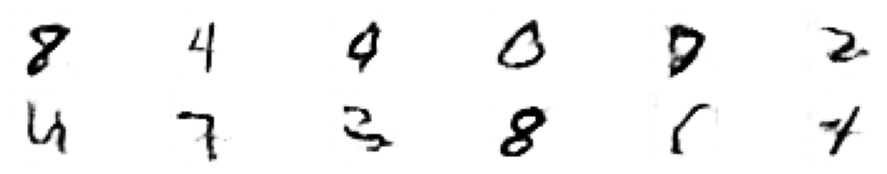

1094/1094 [==============================] - 29s 27ms/step - c_loss: -2.4471 - c_wass_loss: -2.9528 - c_gp: 0.0506 - g_loss: -1.3676
Epoch 11/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -2.3866 - c_wass_loss: -2.8833 - c_gp: 0.0497 - g_loss: -1.4447

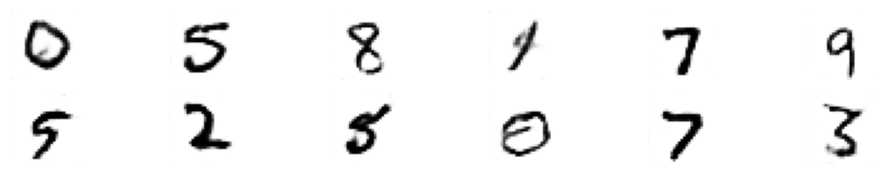

1094/1094 [==============================] - 27s 24ms/step - c_loss: -2.3865 - c_wass_loss: -2.8832 - c_gp: 0.0497 - g_loss: -1.4451
Epoch 12/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -2.3084 - c_wass_loss: -2.7722 - c_gp: 0.0464 - g_loss: -1.3021

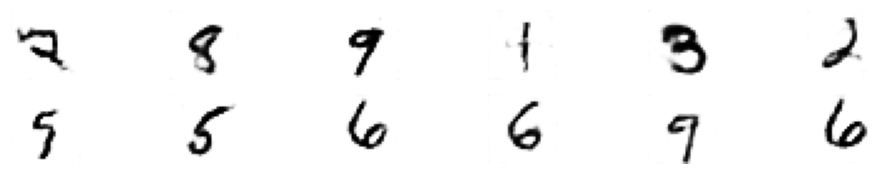

1094/1094 [==============================] - 28s 25ms/step - c_loss: -2.3093 - c_wass_loss: -2.7736 - c_gp: 0.0464 - g_loss: -1.3021
Epoch 13/15
1092/1094 [============================>.] - ETA: 0s - c_loss: -2.2070 - c_wass_loss: -2.6562 - c_gp: 0.0449 - g_loss: -1.7081

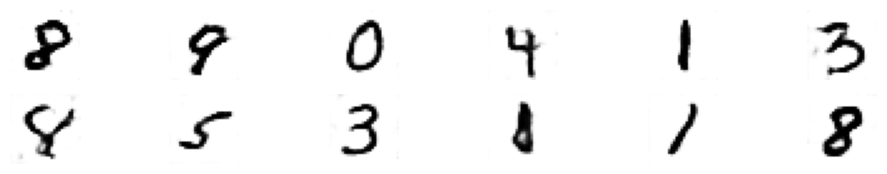

1094/1094 [==============================] - 28s 26ms/step - c_loss: -2.2067 - c_wass_loss: -2.6555 - c_gp: 0.0449 - g_loss: -1.7077
Epoch 14/15
1094/1094 [==============================] - ETA: 0s - c_loss: -2.1604 - c_wass_loss: -2.5932 - c_gp: 0.0433 - g_loss: -1.6504

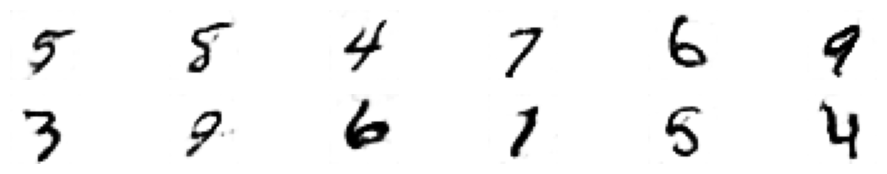

1094/1094 [==============================] - 28s 25ms/step - c_loss: -2.1604 - c_wass_loss: -2.5932 - c_gp: 0.0433 - g_loss: -1.6504
Epoch 15/15
1093/1094 [============================>.] - ETA: 0s - c_loss: -2.1494 - c_wass_loss: -2.5841 - c_gp: 0.0435 - g_loss: -1.7125

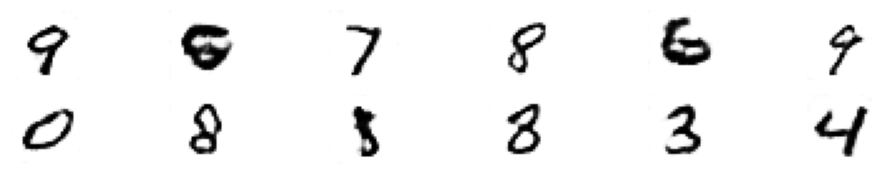

1094/1094 [==============================] - 28s 26ms/step - c_loss: -2.1488 - c_wass_loss: -2.5836 - c_gp: 0.0435 - g_loss: -1.7123
Epoch 1/15
545/547 [============================>.] - ETA: 0s - c_loss: -2.0466 - c_wass_loss: -2.4536 - c_gp: 0.0407 - g_loss: -1.7148

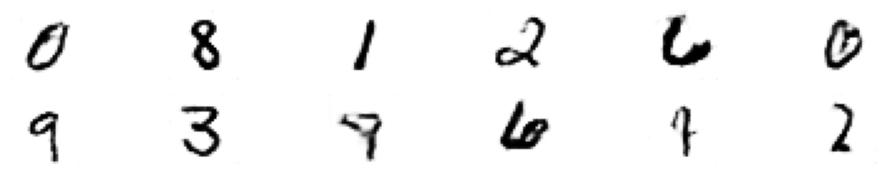

547/547 [==============================] - 14s 26ms/step - c_loss: -2.0461 - c_wass_loss: -2.4531 - c_gp: 0.0407 - g_loss: -1.7144
Epoch 8/15
546/547 [============================>.] - ETA: 0s - c_loss: -2.0637 - c_wass_loss: -2.4810 - c_gp: 0.0417 - g_loss: -1.6220

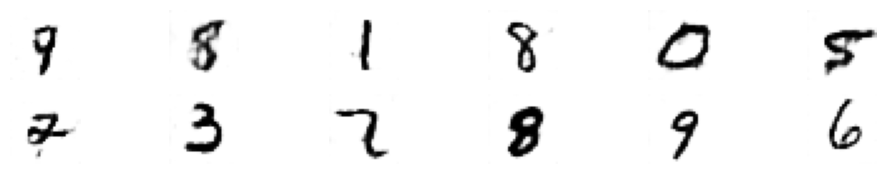

547/547 [==============================] - 14s 26ms/step - c_loss: -2.0646 - c_wass_loss: -2.4821 - c_gp: 0.0418 - g_loss: -1.6214
Epoch 9/15
545/547 [============================>.] - ETA: 0s - c_loss: -2.0243 - c_wass_loss: -2.4207 - c_gp: 0.0396 - g_loss: -1.8303

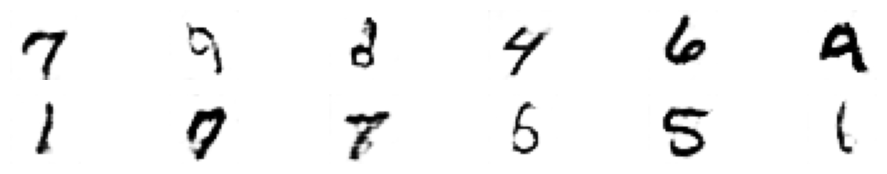

547/547 [==============================] - 14s 26ms/step - c_loss: -2.0235 - c_wass_loss: -2.4202 - c_gp: 0.0397 - g_loss: -1.8318
Epoch 10/15
547/547 [==============================] - ETA: 0s - c_loss: -2.0333 - c_wass_loss: -2.4425 - c_gp: 0.0409 - g_loss: -1.7352

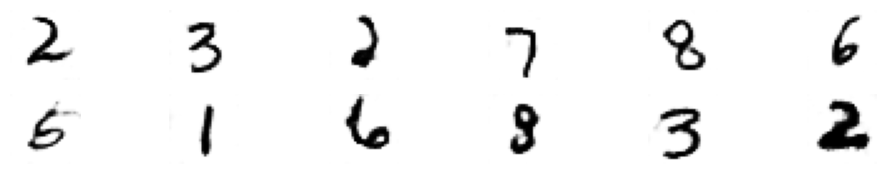

547/547 [==============================] - 14s 26ms/step - c_loss: -2.0333 - c_wass_loss: -2.4425 - c_gp: 0.0409 - g_loss: -1.7352
Epoch 11/15
546/547 [============================>.] - ETA: 0s - c_loss: -1.9935 - c_wass_loss: -2.3928 - c_gp: 0.0399 - g_loss: -1.9380

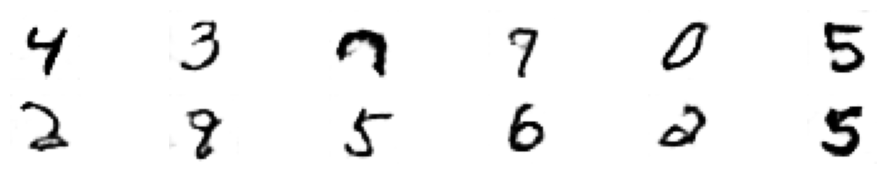

547/547 [==============================] - 14s 26ms/step - c_loss: -1.9932 - c_wass_loss: -2.3922 - c_gp: 0.0399 - g_loss: -1.9370
Epoch 12/15
546/547 [============================>.] - ETA: 0s - c_loss: -2.0579 - c_wass_loss: -2.4708 - c_gp: 0.0413 - g_loss: -1.7719

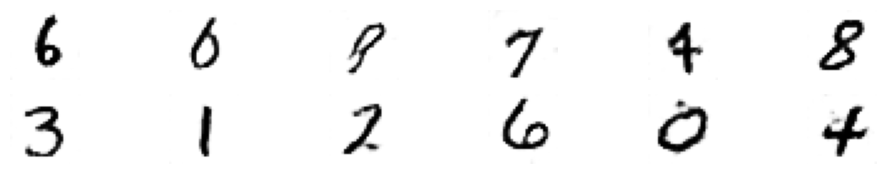

547/547 [==============================] - 14s 26ms/step - c_loss: -2.0576 - c_wass_loss: -2.4702 - c_gp: 0.0413 - g_loss: -1.7731
Epoch 13/15
546/547 [============================>.] - ETA: 0s - c_loss: -2.0336 - c_wass_loss: -2.4471 - c_gp: 0.0414 - g_loss: -1.6820

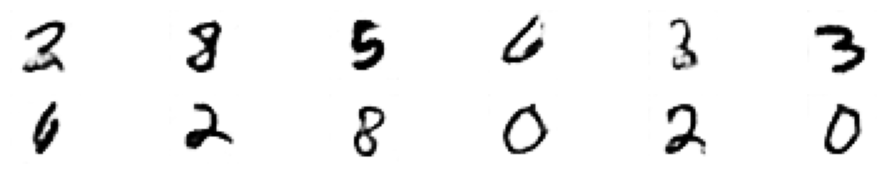

547/547 [==============================] - 14s 26ms/step - c_loss: -2.0327 - c_wass_loss: -2.4465 - c_gp: 0.0414 - g_loss: -1.6823
Epoch 14/15
547/547 [==============================] - ETA: 0s - c_loss: -2.0323 - c_wass_loss: -2.4410 - c_gp: 0.0409 - g_loss: -1.8382

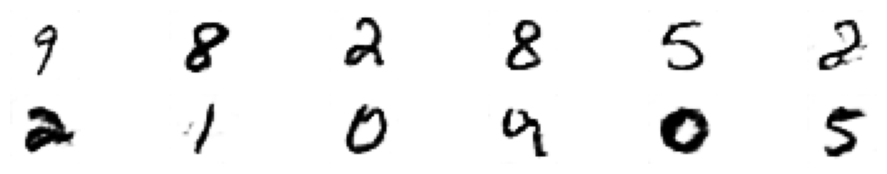

547/547 [==============================] - 14s 26ms/step - c_loss: -2.0323 - c_wass_loss: -2.4410 - c_gp: 0.0409 - g_loss: -1.8382
Epoch 15/15
547/547 [==============================] - ETA: 0s - c_loss: -1.9690 - c_wass_loss: -2.3526 - c_gp: 0.0384 - g_loss: -1.9298

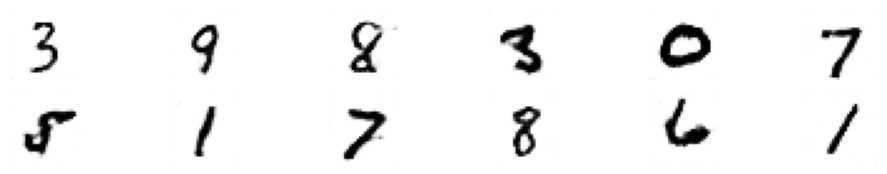

547/547 [==============================] - 16s 29ms/step - c_loss: -1.9690 - c_wass_loss: -2.3526 - c_gp: 0.0384 - g_loss: -1.9298
Epoch 1/15
273/274 [============================>.] - ETA: 0s - c_loss: -2.0549 - c_wass_loss: -2.4558 - c_gp: 0.0401 - g_loss: -1.7298

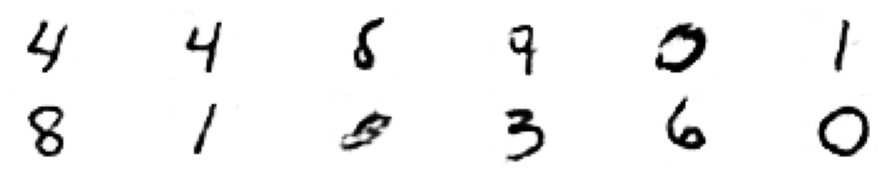

274/274 [==============================] - 9s 32ms/step - c_loss: -2.0549 - c_wass_loss: -2.4566 - c_gp: 0.0402 - g_loss: -1.7286
Epoch 2/15
273/274 [============================>.] - ETA: 0s - c_loss: -2.0125 - c_wass_loss: -2.4126 - c_gp: 0.0400 - g_loss: -1.9834

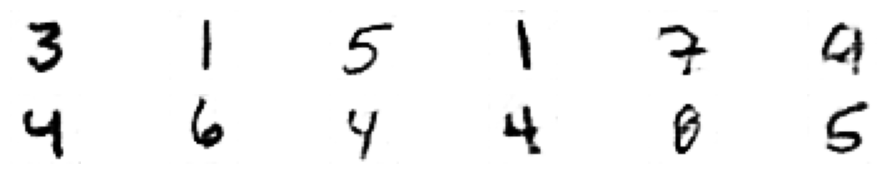

274/274 [==============================] - 9s 32ms/step - c_loss: -2.0126 - c_wass_loss: -2.4132 - c_gp: 0.0401 - g_loss: -1.9836
Epoch 3/15
273/274 [============================>.] - ETA: 0s - c_loss: -2.0719 - c_wass_loss: -2.4869 - c_gp: 0.0415 - g_loss: -1.8382

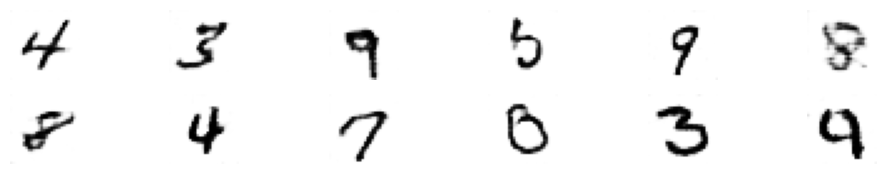

274/274 [==============================] - 9s 32ms/step - c_loss: -2.0711 - c_wass_loss: -2.4860 - c_gp: 0.0415 - g_loss: -1.8366
Epoch 4/15
273/274 [============================>.] - ETA: 0s - c_loss: -2.0587 - c_wass_loss: -2.4603 - c_gp: 0.0402 - g_loss: -1.8337

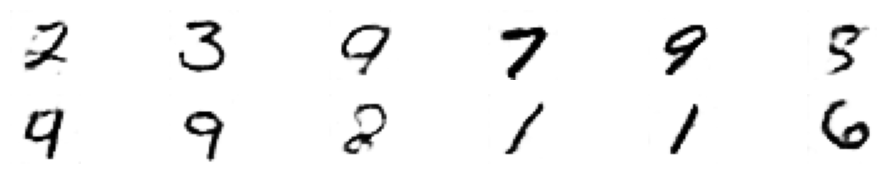

274/274 [==============================] - 9s 32ms/step - c_loss: -2.0600 - c_wass_loss: -2.4613 - c_gp: 0.0401 - g_loss: -1.8373
Epoch 5/15
273/274 [============================>.] - ETA: 0s - c_loss: -2.0590 - c_wass_loss: -2.4720 - c_gp: 0.0413 - g_loss: -1.8745

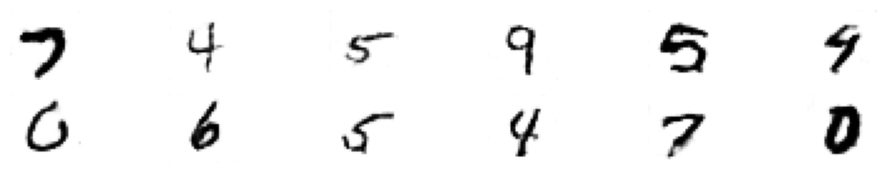

274/274 [==============================] - 9s 32ms/step - c_loss: -2.0571 - c_wass_loss: -2.4696 - c_gp: 0.0412 - g_loss: -1.8785
Epoch 6/15
273/274 [============================>.] - ETA: 0s - c_loss: -2.0751 - c_wass_loss: -2.4849 - c_gp: 0.0410 - g_loss: -1.8637

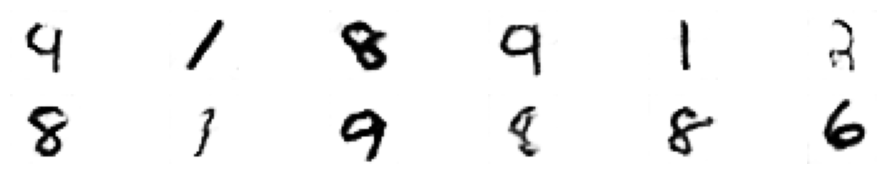

274/274 [==============================] - 9s 33ms/step - c_loss: -2.0751 - c_wass_loss: -2.4845 - c_gp: 0.0409 - g_loss: -1.8654
Epoch 7/15
273/274 [============================>.] - ETA: 0s - c_loss: -2.0581 - c_wass_loss: -2.4733 - c_gp: 0.0415 - g_loss: -1.8646

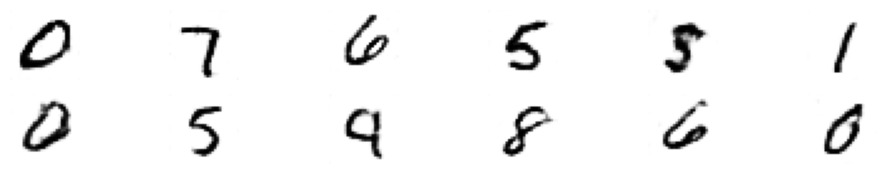

274/274 [==============================] - 9s 32ms/step - c_loss: -2.0576 - c_wass_loss: -2.4722 - c_gp: 0.0415 - g_loss: -1.8643
Epoch 8/15
 85/274 [========>.....................] - ETA: 5s - c_loss: -2.1156 - c_wass_loss: -2.5500 - c_gp: 0.0434 - g_loss: -1.9027

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [388]:
gan_monitor_cb = GANMonitor(samples_count=12)

batch_size_increases = 3
initial_batch_size = 64

for i in range(batch_size_increases):
    wgangp.fit(
        X,
        epochs=15,
        batch_size=initial_batch_size*(2**i),
        callbacks=[gan_monitor_cb]
    )

In [389]:
wgangp.generator.save("generator2.h5")
wgangp.critic.save("critic2.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


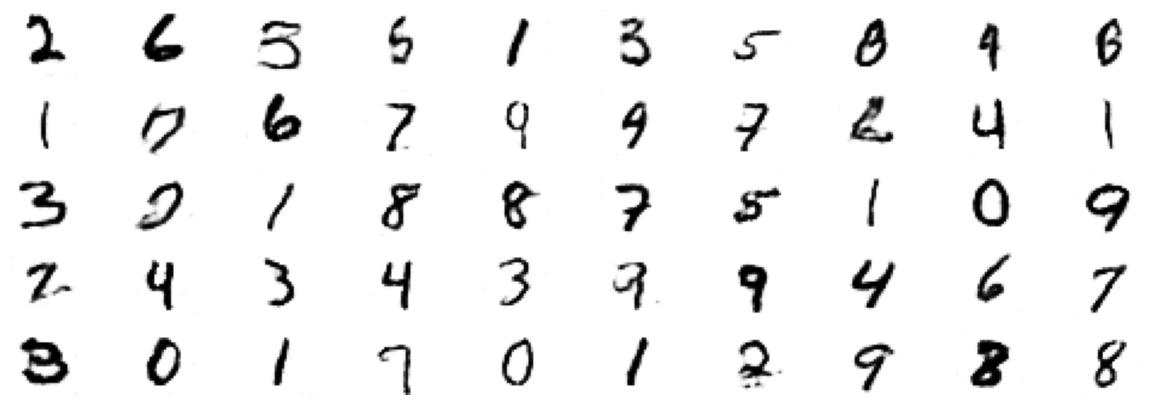

In [15]:
# Load the generator
generator = keras.models.load_model("generator1.h5")

# Genrate 10 random images
total_images = 50
random_latent_vectors = tf.random.normal(shape=(50, 25))
fake_images = generator(random_latent_vectors)

rows = total_images//10
cols = 10

plt.figure(figsize=(15, 5))
for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, i * 10 + j + 1)
        plt.imshow(fake_images[i*10 + j].numpy().reshape(28, 28), cmap="binary")
        plt.axis("off")